In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyxdf

%matplotlib inline

# Analyze screen flicker delay/jitter

## Load lsl recording

In [22]:
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-001_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-005_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_psychopy_run-001_eeg.xdf'
fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
# fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg_old1.xdf'
# fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-slow_erp_test_run-003_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-pyglet_slow_erp_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-pyglet_fast_erp_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-new-monitor-test_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-new_monitor_test_run-002_eeg.xdf"

fpath = 'D:/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-test_run_run-001_eeg.xdf'
fpath = "../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_flip_test_run-001_eeg.xdf"
# "D:\Documents\CurrentStudy\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-test_run_run-001_eeg.xdf"
streams, header = pyxdf.load_xdf(fpath)

for stream in streams:
    print(stream['info']['name'])

['ScreenSensorStream']
['MarkerStream']


In [23]:
marker_stream = [s for s in streams if s['info']['name'][0] == 'MarkerStream'][0]
sensor_stream = [s for s in streams if s['info']['name'][0] == 'ScreenSensorStream'][0]

marker_timestamp = marker_stream['time_stamps']
marker_timeseries = marker_stream['time_series'].flatten()
sensor_timestamp = sensor_stream['time_stamps']
sensor_timeseries = sensor_stream['time_series'].flatten()

## Check if marker is the same as codebook

In [24]:
# CHeck if marker time_series is the same as codebook
from utils import load_codebooks_block_3
codebook = load_codebooks_block_3()[0, :, 0]

trial_start_idx = np.where(marker_timeseries == 200)[0][0]
trial_end_idx = np.where(marker_timeseries == 210)[0][0]
marker_timeseries = marker_timeseries[trial_start_idx+1:trial_end_idx]
marker_timestamp = marker_timestamp[trial_start_idx+1:trial_end_idx]
marker_timeseries = (marker_timeseries == 110).astype(int)

np.array_equal(codebook, marker_timeseries)


True

## Clip start and end time

In [25]:
sensor_timeseries = sensor_timeseries[(sensor_timestamp > marker_timestamp[0]) & (sensor_timestamp < marker_timestamp[-1] + 0.025)]
sensor_timestamp = sensor_timestamp[(sensor_timestamp > marker_timestamp[0]) & (sensor_timestamp < marker_timestamp[-1] + 0.025)]
print(sensor_timeseries.shape, sensor_timestamp.shape)

%matplotlib qt
plt.plot(marker_timestamp, marker_timeseries, marker='o', label='marker')
plt.plot(sensor_timestamp, sensor_timeseries, marker='x', label='sensor')
plt.legend()
plt.show()


(384,) (384,)


## remove consecutive equal values from markers

In [26]:
new_idc = [0]
for i in range(1, len(marker_timeseries)):
    if marker_timeseries[i] != marker_timeseries[i - 1]:
        new_idc.append(i)

marker_timeseries = marker_timeseries[new_idc]
marker_timestamp = marker_timestamp[new_idc]

%matplotlib qt
plt.plot(marker_timestamp, marker_timeseries, marker='o', label='marker')
plt.plot(sensor_timestamp, sensor_timeseries, marker='x', label='sensor')
plt.legend()
plt.show()


## Filter sensor jitter

In [27]:
df_marker = pd.DataFrame(
    {
        'timestamp': marker_timestamp,
        'value': marker_timeseries
    }
)
df_sensor = pd.DataFrame(
    {
        'timestamp_sensor': sensor_timestamp,
        'value_sensor': sensor_timeseries
    }
)

df_merged = pd.merge_asof(df_marker, df_sensor, left_on='timestamp', right_on='timestamp_sensor', direction='nearest', tolerance=0.01)
print(df_merged.shape)
print(df_merged.head())
print('\n# of NaNs:')
print(df_merged.isna().sum())

(384, 4)
     timestamp  value  timestamp_sensor  value_sensor
0  2569.238316      0               NaN           NaN
1  2569.254976      1       2569.258787           1.0
2  2569.271667      0       2569.274272           0.0
3  2569.288311      1       2569.291481           1.0
4  2569.304977      0       2569.307432           0.0

# of NaNs:
timestamp           0
value               0
timestamp_sensor    1
value_sensor        1
dtype: int64


In [28]:
%matplotlib qt
plt.plot(marker_timestamp, marker_timeseries, marker='o', label='marker')
plt.plot(sensor_timestamp, sensor_timeseries, marker='x', label='sensor')
plt.plot(df_merged['timestamp_sensor'], df_merged['value_sensor'], marker='x', label='sensor_filtered')
plt.legend()
plt.show()

Mean delay: 0.003120244713199748
Delay std: 0.000397815913228756


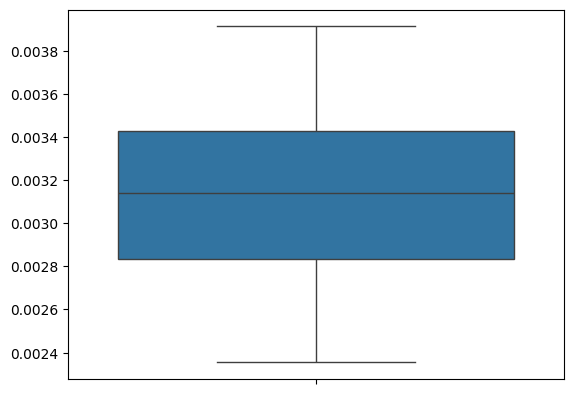

In [29]:
%matplotlib inline
diff = df_merged['timestamp_sensor'] - df_merged['timestamp']
print('Mean delay:', diff.mean())
print('Delay std:', diff.std())
plt.clf()
plt.cla()
sns.boxplot(df_merged['timestamp_sensor'] - df_merged['timestamp'])
plt.show()

In [30]:
# Mean delay: 0.003139559622785386
# Delay std: 0.0004232748245344668

In [20]:
%matplotlib qt
plt.scatter(df_merged['timestamp'], np.zeros_like(df_merged['timestamp']), marker='o', label='sensor_filtered')
plt.scatter(df_merged['timestamp_sensor'], np.zeros_like(df_merged['timestamp_sensor']), marker='x', label='sensor_filtered')
plt.show()